In [1]:
import os
import numpy as np
import yaml
import pandas as pd

Simple Functions

In [2]:
def get_yaml_data_from_arxiv_number(arxiv_number):
    with open(os.path.join('..', f'{arxiv_number}', f'{arxiv_number}.yaml'), 'r') as f:
        return yaml.safe_load(f)

In [24]:
with open('../prompt_classification.yaml', 'r') as f:
    prompt_classification = yaml.safe_load(f)

In [29]:
is_ambigous_dict = {}
for task in prompt_classification:
    if task['task'] not in is_ambigous_dict:
        if 'placeholder' in task:
            is_ambigous_dict[task['task']] = [key for key,val in task['placeholder'].items() if val == 'A']

# Dataset

In [3]:
arxiv_number_list = [
    "1010.1819",
    "1106.6060",
    "1208.0116",
    # "1212.5363", # TODO
    "1310.2674",
    "1812.04213",
    "2004.04168",
    "2008.08998",
    "2012.04554",
    "2108.02159",
    "2110.11330",
    "2111.01152",
    "2112.07523",
    "2308.03843",
    "2308.07488",
]


def get_branch_from_arxiv_number(arxiv_number):
    yaml_data = get_yaml_data_from_arxiv_number(arxiv_number=arxiv_number)
    return yaml_data[0]["branch"]


# Keeps the pd.Series nicely ordered from the start
arxiv_number_list.sort(key=get_branch_from_arxiv_number)

# Construct List of Tuple Indices and Data

In [33]:
tuple_index_list = []
score_list = []

for arxiv_number in arxiv_number_list:
    yaml_data = get_yaml_data_from_arxiv_number(arxiv_number)

    # Branch name
    cur_branch_name = yaml_data[0]["branch"]

    # Arxiv number
    cur_arxiv_number = arxiv_number

    for task_dict in yaml_data[1:]:
        # Task name
        cur_task_name = task_dict["task"]

        for placeholder_name, placeholder_data in task_dict["placeholder"].items():
            # Placeholder name
            cur_placeholder_name = placeholder_name
            is_ambiguous = cur_placeholder_name in is_ambigous_dict.get(cur_task_name, [])

            if "score" in placeholder_data:  # Some entries in tasks don't have a score
                for scorer, score in placeholder_data["score"].items():
                    cur_scorer = scorer

                    tuple_index_list.append(
                        (
                            cur_branch_name,
                            cur_arxiv_number,
                            cur_task_name,
                            cur_placeholder_name,
                            cur_scorer,
                            is_ambiguous,
                        )
                    )

                    if score is None:
                        cur_score = '(TODO)'
                    else:
                        cur_score = score
                    score_list.append(cur_score)

# Create Pandas Series using MultiIndex

In [35]:
index = pd.MultiIndex.from_tuples(tuple_index_list, names=['branch', 'arxiv', 'task','placeholder', 'scorer','is_ambiguous'])
# data = pd.Series(score_list, index=index, name='score')
data = pd.DataFrame({'Value': score_list}, index=index)


In [36]:
data.xs(key='Haining',level='scorer')

Value
branch                     arxiv      task                                               placeholder                      is_ambiguous      
continuum, first-quantized 1010.1819  Construct Kinetic Hamiltonian (continuum versio... system                           False            1
                                                                                         real|momentum                    False            0
                                                                                         single-particle|second-quantized True             0
                                                                                         degrees_of_freedom               False            1
                                                                                         kinetic_symbol                   False            0
...                                                                                                                                      ...
lattice, second-quantized  2308.03843 Reduce momentum in Fock term (momentum in BZ)      expected_value                   True             2
                                                                                         expected_value_nonzero           True             2
                                      Combine the Hartree and Fock term                  symbol                           True             2
                                                                                         Fock                             True             2
                                                                                         swap rule                        True             0

[819 rows x 1 columns]

In [18]:
data.to_csv('data.csv')

# Compare different tasks

In [10]:
len(score_list)

2457

In [12]:
index.shape

(2457,)

In [72]:
reading_literally=["definition_of_variables",'degrees_of_freedom','diagonal_potential','offdiagonal_potential','normalization_factor','int_form','interaction','interaction_degrees_of_freedom','parabolic|Dirac|cos','site i and site j with the amplitude hopping','site i and site j with the interaction strength','system']
reading_with_inferring=["$r$|$k$","Energy_dispersion","For each operator, the total momentum is the sum of moire reciprocal lattice $b_i$ and momentum with in the first BZ $k_i$","Ham_op","Note that hopping have no position dependence now.",'Note that interaction have no position dependence now','Note that the sublattice degrees of freedom is suppressed for now and will be stated later','Potential_variables','Unsummed_Indices','You should ensure the hermiticity of the Hamiltonian','electrons|holes','entire_real|first_Brillouin_Zone','entire_space|first_Brillouin_zone','real|momentum','single-particle|second-quantized']
background_knowledge=['annihilation_op','bilinear_op','creation_op','definition_of_Fourier_Transformation','hole_annihilation_op','hole_creation_op','hole_op','particle_op','momentum_creation_op','real_creation_op','particle_annihilation_op','particle_creation_op',]
symbols=['kinetic_symbol',
 'k_symbol',
 'r_symbol',
 'In addition, a shift of {momentum_shift} in the momentum ${k_symbol}$ for {shifted_Ek}, respectively.',
 'nonint_symbol',
 'potential_symbol',
 'second_nonint_symbol',
 'matrix_element_symbol',
 'basis_symbol',
 'second_int_symbol',
 'Hartree_Fock_symbol',
 'Hartree_Fock_term_symbol',
 'Hartree_Fock_second_quantized_symbol',
 'Hartree_second_quantized_symbol',
 'Fock_second_quantized_symbol',
 'symbol',
 'int_symbol',
 'Ham_symbol',
 'dispersion_symbol',
 'density_symbol']

In [57]:
len(set(symbols))-len(symbols)

0

In [73]:
occurrence=data.index.get_level_values('placeholder').value_counts().to_dict()

In [75]:
reading_literally_sorted=sorted(reading_literally,key=occurrence.get,reverse=True)
for key in reading_literally_sorted:
    print(f'{key}:{occurrence[key]}')
reading_literally_compare_list=reading_literally_sorted

definition_of_variables:285
degrees_of_freedom:63
system:42
normalization_factor:21
int_form:21
interaction:21
parabolic|Dirac|cos:21
site i and site j with the amplitude hopping:21
site i and site j with the interaction strength:21
diagonal_potential:12
offdiagonal_potential:12
interaction_degrees_of_freedom:12


In [189]:
reading_with_inferring_sorted=sorted(reading_with_inferring,key=occurrence.get,reverse=True)
for key in reading_with_inferring_sorted:
    print(f'{key}:{occurrence[key]}')
reading_with_inferring_compare_list=['single-particle|second-quantized','real|momentum','Energy_dispersion','electrons|holes','Unsummed_Indices','$r$|$k$','entire_real|first_Brillouin_Zone','entire_space|first_Brillouin_zone']

single-particle|second-quantized:75
real|momentum:66
Energy_dispersion:21
For each operator, the total momentum is the sum of moire reciprocal lattice $b_i$ and momentum with in the first BZ $k_i$:21
Note that hopping have no position dependence now.:21
Note that interaction have no position dependence now:21
You should ensure the hermiticity of the Hamiltonian:21
electrons|holes:21
Unsummed_Indices:18
Note that the sublattice degrees of freedom is suppressed for now and will be stated later:15
$r$|$k$:12
Potential_variables:12
entire_real|first_Brillouin_Zone:6
entire_space|first_Brillouin_zone:6
Ham_op:3


In [204]:
background_knowledge_sorted=sorted(background_knowledge,key=occurrence.get,reverse=True)
for key in background_knowledge_sorted:
    print(f'{key}:{occurrence[key]}')
background_knowledge_compare_list=background_knowledge_sorted[:4]

definition_of_Fourier_Transformation:48
momentum_creation_op:48
real_creation_op:48
bilinear_op:42
annihilation_op:6
creation_op:6
hole_op:6
hole_annihilation_op:3
hole_creation_op:3
particle_op:3
particle_annihilation_op:3
particle_creation_op:3


In [213]:
symbols_sorted=sorted(symbols,key=occurrence.get,reverse=True)
for key in symbols_sorted:
    print(f'{key}:{occurrence[key]}')
symbols_compare_list=symbols_sorted[:10]

Hartree_Fock_second_quantized_symbol:114
kinetic_symbol:111
second_int_symbol:105
Hartree_Fock_symbol:57
Hartree_Fock_term_symbol:42
potential_symbol:36
second_nonint_symbol:36
nonint_symbol:33
Hartree_second_quantized_symbol:33
Fock_second_quantized_symbol:27
k_symbol:21
r_symbol:21
In addition, a shift of {momentum_shift} in the momentum ${k_symbol}$ for {shifted_Ek}, respectively.:21
density_symbol:21
symbol:18
int_symbol:15
Ham_symbol:15
matrix_element_symbol:12
basis_symbol:12
dispersion_symbol:6


In [235]:
symbols_compare_list

['Hartree_Fock_second_quantized_symbol',
 'kinetic_symbol',
 'second_int_symbol',
 'Hartree_Fock_symbol',
 'Hartree_Fock_term_symbol',
 'potential_symbol',
 'second_nonint_symbol',
 'nonint_symbol',
 'Hartree_second_quantized_symbol',
 'Fock_second_quantized_symbol']

In [ ]:
compare_list=['real|momentum','single-particle|second-quantized','degrees_of_freedom','definition_of_variables','definition_of_Fourier_Transformation','system','parabolic|Dirac|cos',]

In [46]:
[index for index in data.index.get_level_values('placeholder').unique() if 'symbol' in index]

['kinetic_symbol',
 'k_symbol',
 'r_symbol',
 'In addition, a shift of {momentum_shift} in the momentum ${k_symbol}$ for {shifted_Ek}, respectively.',
 'nonint_symbol',
 'potential_symbol',
 'second_nonint_symbol',
 'matrix_element_symbol',
 'basis_symbol',
 'second_int_symbol',
 'Hartree_Fock_symbol',
 'Hartree_Fock_term_symbol',
 'Hartree_Fock_second_quantized_symbol',
 'Hartree_second_quantized_symbol',
 'Fock_second_quantized_symbol',
 'symbol',
 'int_symbol',
 'Ham_symbol',
 'dispersion_symbol',
 'density_symbol']

In [48]:
set(data.index.get_level_values('placeholder').unique())-set(symbols)

{'$r$|$k$',
 'Energy_dispersion',
 'Fock',
 'For each operator, the total momentum is the sum of moire reciprocal lattice $b_i$ and momentum with in the first BZ $k_i$',
 'Ham_op',
 'Note that hopping have no position dependence now.',
 'Note that interaction have no position dependence now',
 'Note that the sublattice degrees of freedom is suppressed for now and will be stated later',
 'Potential_variables',
 'Unsummed_Indices',
 'You should ensure the hermiticity of the Hamiltonian',
 'annihilation_op',
 'bilinear_op',
 'creation_op',
 'definition_of_Fourier_Transformation',
 'definition_of_variables',
 'degrees_of_freedom',
 'diagonal_potential',
 'electrons|holes',
 'entire_real|first_Brillouin_Zone',
 'entire_space|first_Brillouin_zone',
 'expected_value',
 'expected_value_Hartree',
 'expected_value_nonzero',
 'expression_Hartree_1',
 'expression_Hartree_2',
 'expression_diag',
 'expression_int',
 'expression_kinetic',
 'expression_offdiag',
 'hole_annihilation_op',
 'hole_creatio

In [44]:
[for ]

definition_of_variables                 285
Hartree_Fock_second_quantized_symbol    114
kinetic_symbol                          111
second_int_symbol                       105
expected_value                           96
single-particle|second-quantized         75
real|momentum                            66
degrees_of_freedom                       63
expected_value_nonzero                   57
Hartree_Fock_symbol                      57
Name: placeholder, dtype: int64

In [37]:
data.xs(key='Haining',level='scorer')

Value
branch                     arxiv      task                                               placeholder                      is_ambiguous      
continuum, first-quantized 1010.1819  Construct Kinetic Hamiltonian (continuum versio... system                           False            1
                                                                                         real|momentum                    False            0
                                                                                         single-particle|second-quantized True             0
                                                                                         degrees_of_freedom               False            1
                                                                                         kinetic_symbol                   False            0
...                                                                                                                                      ...
lattice, second-quantized  2308.03843 Reduce momentum in Fock term (momentum in BZ)      expected_value                   True             2
                                                                                         expected_value_nonzero           True             2
                                      Combine the Hartree and Fock term                  symbol                           True             2
                                                                                         Fock                             True             2
                                                                                         swap rule                        True             0

[819 rows x 1 columns]

In [ ]:
data.xs(key='Haining',level='scorer')

## Comparing results

### Reading ability

In [228]:
reading_literally_score={scorer:{ph:pd.to_numeric(data.xs(key=ph,level='placeholder').xs(key=scorer,level='scorer')['Value'],errors='coerce').dropna().mean() for ph in reading_literally_compare_list} for scorer in ['Haining','Yasaman']}

In [229]:
sorted_keys = [list(reading_literally_score['Haining'].keys())[i] for i in np.argsort(np.array(list(reading_literally_score['Haining'].values()))+np.array(list(reading_literally_score['Yasaman'].values())))[::-1]]

In [230]:
reading_literally_score_sorted={scorer:{k: reading_literally_score[scorer][k] for k in sorted_keys} for scorer in reading_literally_score.keys()}

In [231]:
reading_literally_score_sorted['Haining'].keys()==reading_literally_score_sorted['Yasaman'].keys()

True

In [232]:
import matplotlib.pyplot as plt
import numpy as np

In [233]:
np.mean([list(val.values()) for val in reading_literally_score_sorted.values()])

1.349589971639454

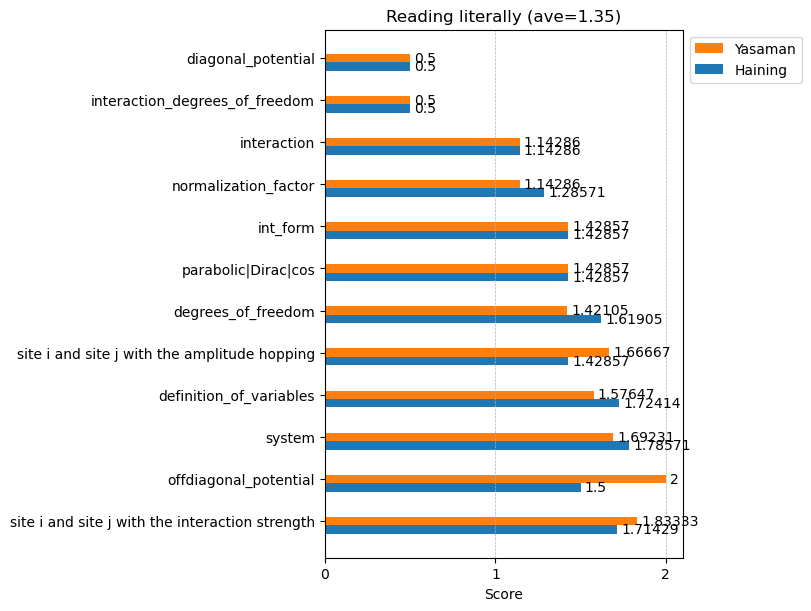

In [234]:
tasks=reading_literally_score_sorted['Haining'].keys()

x = np.arange(len(reading_literally_score_sorted['Haining'].keys()))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',figsize=(8,6))

for attribute, measurement in reading_literally_score_sorted.items():
    offset = width * multiplier
    rects = ax.barh(x + offset, list(measurement.values()), width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xlabel('Score')
ax.set_xticks([0,1,2])

ax.set_title(f'Reading literally (ave={np.mean([list(val.values()) for val in reading_literally_score_sorted.values()]):.2f})')
ax.set_yticks(x + width, tasks)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1],loc='upper left', ncols=1,bbox_to_anchor=(1, 1))

ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)



### Reading_with_inferring

In [190]:
reading_with_inferring_score={scorer:{ph:pd.to_numeric(data.xs(key=ph,level='placeholder').xs(key=scorer,level='scorer')['Value'],errors='coerce').dropna().mean() for ph in reading_with_inferring_compare_list} for scorer in ['Haining','Yasaman']}

In [192]:
sorted_keys = [list(reading_with_inferring_score['Haining'].keys())[i] for i in np.argsort(np.array(list(reading_with_inferring_score['Haining'].values()))+np.array(list(reading_with_inferring_score['Yasaman'].values())))[::-1]]

In [193]:
reading_with_inferring_score_sorted={scorer:{k: reading_with_inferring_score[scorer][k] for k in sorted_keys} for scorer in ['Haining','Yasaman']}

In [195]:
reading_with_inferring_score_sorted['Haining'].keys()==reading_with_inferring_score_sorted['Yasaman'].keys()

True

In [196]:
np.mean([list(val.values()) for val in reading_with_inferring_score_sorted.values()])

1.2731580557124036

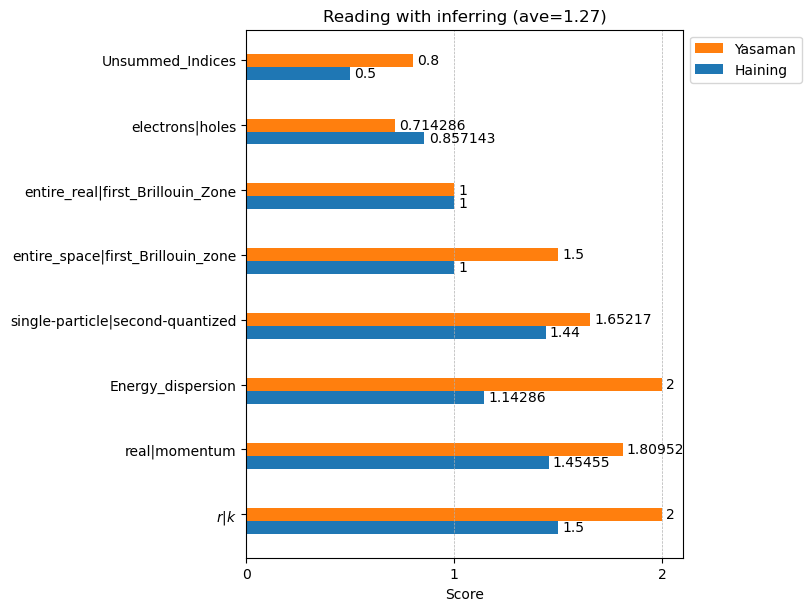

In [212]:
tasks=reading_with_inferring_score_sorted['Haining'].keys()

x = np.arange(len(reading_with_inferring_score_sorted['Haining'].keys()))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',figsize=(8,6))

for attribute, measurement in reading_with_inferring_score_sorted.items():
    offset = width * multiplier
    rects = ax.barh(x + offset, list(measurement.values()), width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xlabel('Score')
ax.set_xticks([0,1,2])

ax.set_title(f'Reading with inferring (ave={np.mean([list(val.values()) for val in reading_with_inferring_score_sorted.values()]):.2f})')
ax.set_yticks(x + width, tasks)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1],loc='upper left', ncols=1,bbox_to_anchor=(1, 1))

ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)



### background_knowledge_sorted

In [205]:
background_knowledge_sorted

['definition_of_Fourier_Transformation',
 'momentum_creation_op',
 'real_creation_op',
 'bilinear_op',
 'annihilation_op',
 'creation_op',
 'hole_op',
 'hole_annihilation_op',
 'hole_creation_op',
 'particle_op',
 'particle_annihilation_op',
 'particle_creation_op']

In [206]:
background_knowledge_score={scorer:{ph:pd.to_numeric(data.xs(key=ph,level='placeholder').xs(key=scorer,level='scorer')['Value'],errors='coerce').dropna().mean() for ph in background_knowledge_compare_list} for scorer in ['Haining','Yasaman']}

In [207]:
sorted_keys = [list(background_knowledge_score['Haining'].keys())[i] for i in np.argsort(np.array(list(background_knowledge_score['Haining'].values()))+np.array(list(background_knowledge_score['Yasaman'].values())))[::-1]]

In [208]:
background_knowledge_score_sorted={scorer:{k: background_knowledge_score[scorer][k] for k in sorted_keys} for scorer in ['Haining','Yasaman']}

In [209]:
np.mean([list(val.values()) for val in background_knowledge_score_sorted.values()])

0.7733516483516483

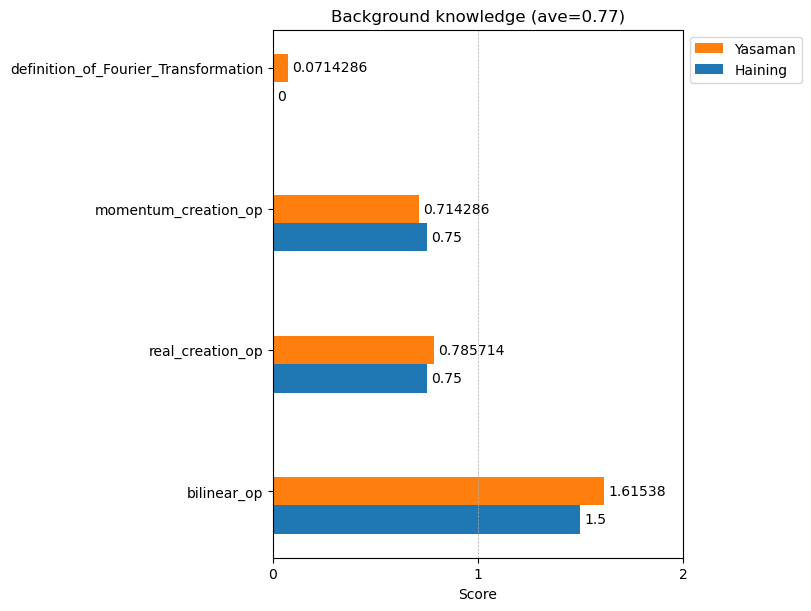

In [211]:
tasks=background_knowledge_score_sorted['Haining'].keys()

x = np.arange(len(background_knowledge_score_sorted['Haining'].keys()))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',figsize=(8,6))

for attribute, measurement in background_knowledge_score_sorted.items():
    offset = width * multiplier
    rects = ax.barh(x + offset, list(measurement.values()), width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xlabel('Score')
ax.set_xticks([0,1,2])

ax.set_title(f'Background knowledge (ave={np.mean([list(val.values()) for val in background_knowledge_score_sorted.values()]):.2f})')
ax.set_yticks(x + width, tasks)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1],loc='upper left', ncols=1,bbox_to_anchor=(1, 1))

ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)



### symbols_sorted

In [215]:
symbols_score={scorer:{ph:pd.to_numeric(data.xs(key=ph,level='placeholder').xs(key=scorer,level='scorer')['Value'],errors='coerce').dropna().mean() for ph in symbols_compare_list} for scorer in ['Haining','Yasaman']}

In [216]:
sorted_keys = [list(symbols_score['Haining'].keys())[i] for i in np.argsort(np.array(list(symbols_score['Haining'].values()))+np.array(list(symbols_score['Yasaman'].values())))[::-1]]

In [218]:
symbols_score_sorted={scorer:{k: symbols_score[scorer][k] for k in sorted_keys} for scorer in ['Haining','Yasaman']}

In [219]:
np.mean([list(val.values()) for val in symbols_score_sorted.values()])

1.3669941462046724

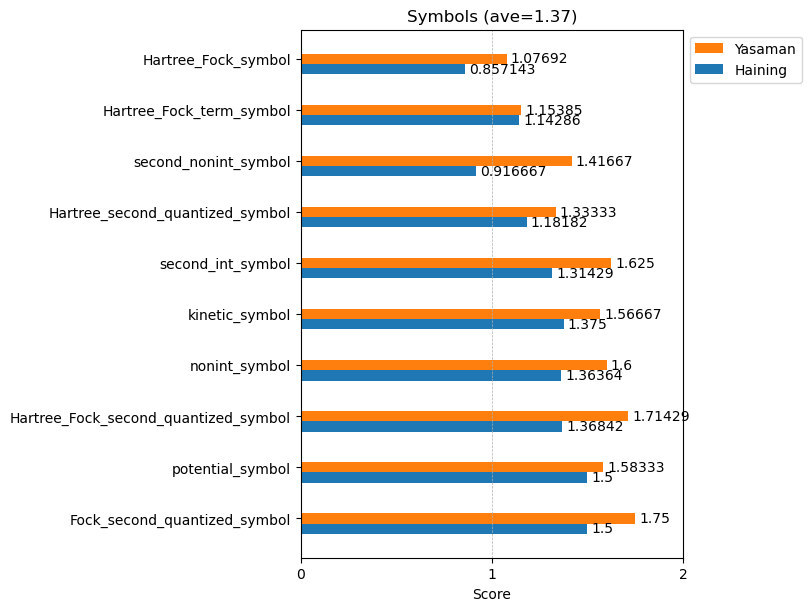

In [221]:
tasks=symbols_score_sorted['Haining'].keys()

x = np.arange(len(symbols_score_sorted['Haining'].keys()))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',figsize=(8,6))

for attribute, measurement in symbols_score_sorted.items():
    offset = width * multiplier
    rects = ax.barh(x + offset, list(measurement.values()), width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_xlabel('Score')
ax.set_xticks([0,1,2])

ax.set_title(f'Symbols (ave={np.mean([list(val.values()) for val in symbols_score_sorted.values()]):.2f})')
ax.set_yticks(x + width, tasks)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1],loc='upper left', ncols=1,bbox_to_anchor=(1, 1))

ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

